# Using dask distributed cluster to speed up computation of PV potential by factor of 10

NOTES 08.12.2024
NAJ: finding maximum values for power consumption in last decade

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
from dask.distributed import Client
import core as core

import warnings
warnings.filterwarnings("ignore")


In [2]:
# location of era5 data on teachinghub
path="~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"

Start dask cluster with 10 processes (workers), each with 5 threads. 

In [3]:
years = [2000]
months = range(6, 6+1)
files = []

files = [f"era5-{year}-{month:02}.nc" for year in years for month in months]

files_path = [path+f for f in files]

print(f"Load data for {years=} {months=}")
files_path

Load data for years=[2000] months=range(6, 7)


['~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-06.nc']

In [4]:
ds=xr.open_mfdataset( files_path, engine="h5netcdf", chunks={"valid_time":1e5} )

In [5]:
ds_eu = ds.sel(latitude=slice(70,35))
# ds_eu = ds_eu.sel(longitude=slice(0,30))
ds
# ds_eu = xr.concat([ds_eu.sel(longitude=slice(0, 35)), ds_eu.sel(longitude=slice(350, 359))], dim='longitude')

ds=xr.open_mfdataset(path+"era5-2000-*.nc", engine="h5netcdf", chunks={"valid_time":1e5} )
ds_1 = ds.sel(latitude=slice(70,35)).sel(longitude=slice(350,359.9))
ds_1['longitude'] = ds_1['longitude'] - 360
ds_eu

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 720, latitude: 141, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-06-01 ... 2000-06-30T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 12kB dask.array<chunksize=(720,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 585MB dask.array<chunksize=(720, 41, 240), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 585MB dask.array<chunksize=(720, 41, 240), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 585MB dask.array<chunksize=(720, 41, 240), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 585MB dask.array<chunksize=(720, 41, 240), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 585MB dask.array<chunksize=(720, 41, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-22T21:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
ds_eu["valid_time"]

<xarray.DataArray 'valid_time' (valid_time: 720)> Size: 6kB
array(['2000-06-01T00:00:00.000000000', '2000-06-01T01:00:00.000000000',
       '2000-06-01T02:00:00.000000000', ..., '2000-06-30T21:00:00.000000000',
       '2000-06-30T22:00:00.000000000', '2000-06-30T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-06-01 ... 2000-06-30T23:...
    expver      (valid_time) <U4 12kB dask.array<chunksize=(720,), meta=np.ndarray>
Attributes:
    long_name:      time
    standard_name:  time

>  PV power potential and production. The PV power output at a site depends on
two factors: its PV power generation potential (PVpot) and the installed capacity.
As defined and used in this study, PVpot is a dimensionless magnitude accounting
for the performance of the PV cells with respect to their nominal power capacity
according to the actual ambient conditions. Therefore, PVpot multiplied by the
nominal installed watts of PV power capacity gives instantaneous PV power
production.
From:  “The impact of climate change on photovoltaic
power generation in Europe.” 

In [7]:
from dask.distributed import progress

from pathlib import Path
home = Path.home()
dask_workspace = home / "daskWorkspace"

# radiation J/m^2
# t2m temperature 2m in K

# Using Dask Client as a context manager
with Client(n_workers=20, threads_per_worker=4, local_directory=dask_workspace) as client:
    print(client)
    start_time = time.time()
    ds=xr.open_mfdataset( files_path, engine="h5netcdf", chunks={"valid_time":1e5} )
    # ds=xr.open_mfdataset(files_path, engine="netcdf4", chunks={"valid_time":1e5} )
    ds["wspd"] = core.windspeed(ds)

    ds_1 = ds.sel(latitude=slice(70,35)).sel(longitude=slice(350,359.9))
    ds_1['longitude'] = ds_1['longitude'] - 360

    ds_2 = ds.sel(latitude=slice(70,35)).sel(longitude=slice(0,30))

    ds_eu = xr.concat([ds_1, ds_2], dim="longitude")
    
    # ds_eu = xr.concat([ds_eu.sel(longitude=slice(0, 35)), ds_eu.sel(longitude=slice(350, 359))], dim='longitude')
    # pvpot = core.pv_pot(ds).groupby(ds.valid_time.dt.month).mean("valid_time").persist()
    # pvpot = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean("valid_time").compute()
    pvpot = core.pv_pot(ds_eu).compute()
    # progress(pvpot)
    # pvpot.compute()
    
    # pvpot = core.pv_pot(ds).mean("valid_time").compute()
    end_time = time.time()
    execution_time = end_time - start_time
print(f"Execution time: {execution_time:.5f} seconds")

<Client: 'tcp://127.0.0.1:44857' processes=20 threads=80, memory=753.83 GiB>
Execution time: 6.45112 seconds


In [8]:
second_month = 3600 * 24 * 30
standard_capacity = 237 # In watts per m^2
energy_month = pvpot * standard_capacity * second_month # Jules per month 1 panel would generate

In [9]:
pvpot.min()

<xarray.DataArray ()> Size: 8B
array(0.)
Coordinates:
    number   int64 8B 0

In [10]:
ds_eu

<xarray.Dataset> Size: 392MB
Dimensions:     (valid_time: 720, latitude: 141, longitude: 161)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-06-01 ... 2000-06-30T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 12kB dask.array<chunksize=(720,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-22T21:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
print(f"{pvpot.shape}")
pvpot

(720, 141, 161)


<xarray.DataArray (valid_time: 720, latitude: 141, longitude: 161)> Size: 65MB
array([[[0.0115664 , 0.01190231, 0.01189722, ..., 0.01075943,
         0.00905249, 0.00721867],
        [0.01074876, 0.01110528, 0.01107951, ..., 0.00886567,
         0.00751669, 0.00657129],
        [0.01068728, 0.01129596, 0.01163023, ..., 0.00783311,
         0.00690155, 0.00597354],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.00687714, 0.00677144, 0.00691707, ..., 0.01378786,
         0.01148715, 0.00909211],
        [0.00524534, 0.00513986, 0.0052857 , ..., 0.0106908 ,
         0.00864295, 0.00710442],
        [0.0044365 , 0.00431064, 0.00439427, ..., 0.0098915 ,
         0.00837963, 0.00687192],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.02729304, 0.02573461, 0.02494851, ..., 0.01812684,
         0.01710492, 0.01607026],
        [0.03063521, 0.02903737, 0.02826958, ..., 0.01707957,
         0.01610785, 0.01568309],
        [0.03948944, 0.03725677, 0.03519104, ..., 0.0167452 ,
         0.01633839, 0.01595137],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-06-01 ... 2000-06-30T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'

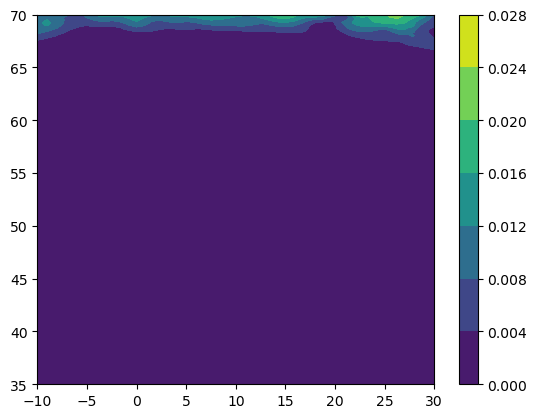

In [12]:
plt.contourf(ds_eu.longitude, ds_eu.latitude, pvpot[0])
plt.colorbar()

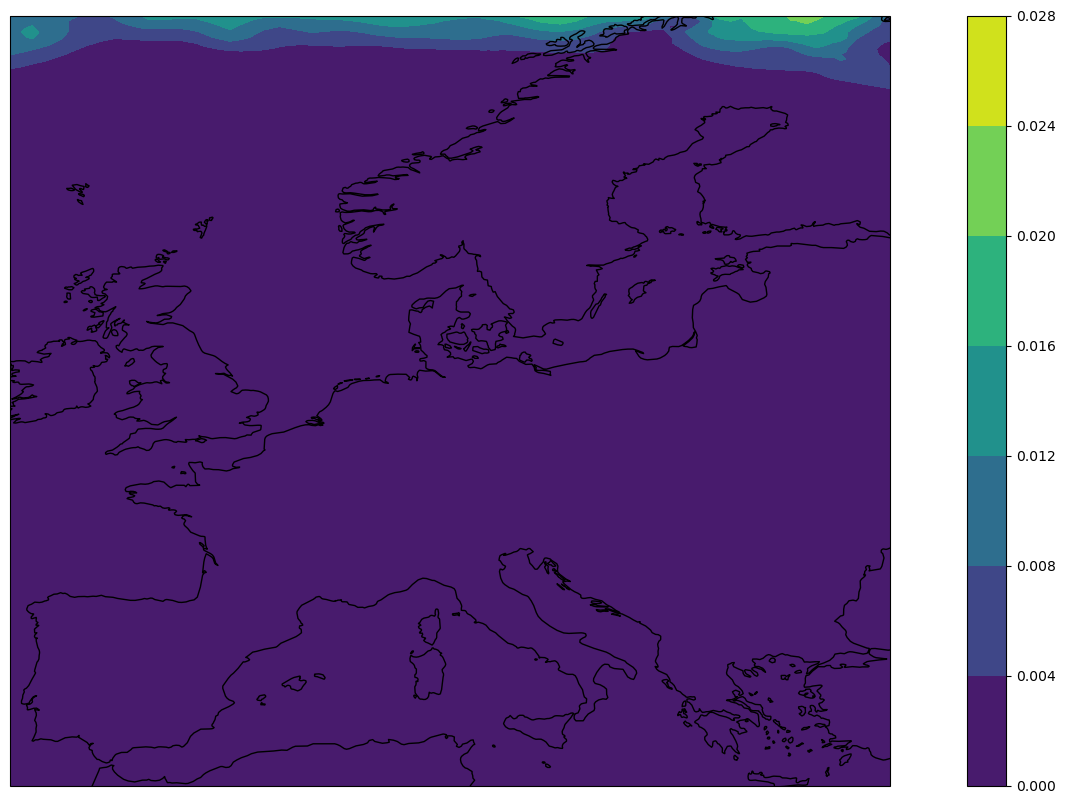

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Create a figure with a specified projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and other features
ax.coastlines()
# ax.add_feature(cfeature.LAND)

# Create contour plot
contour = ax.contourf(ds_eu.longitude, ds_eu.latitude, pvpot[0])

cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)

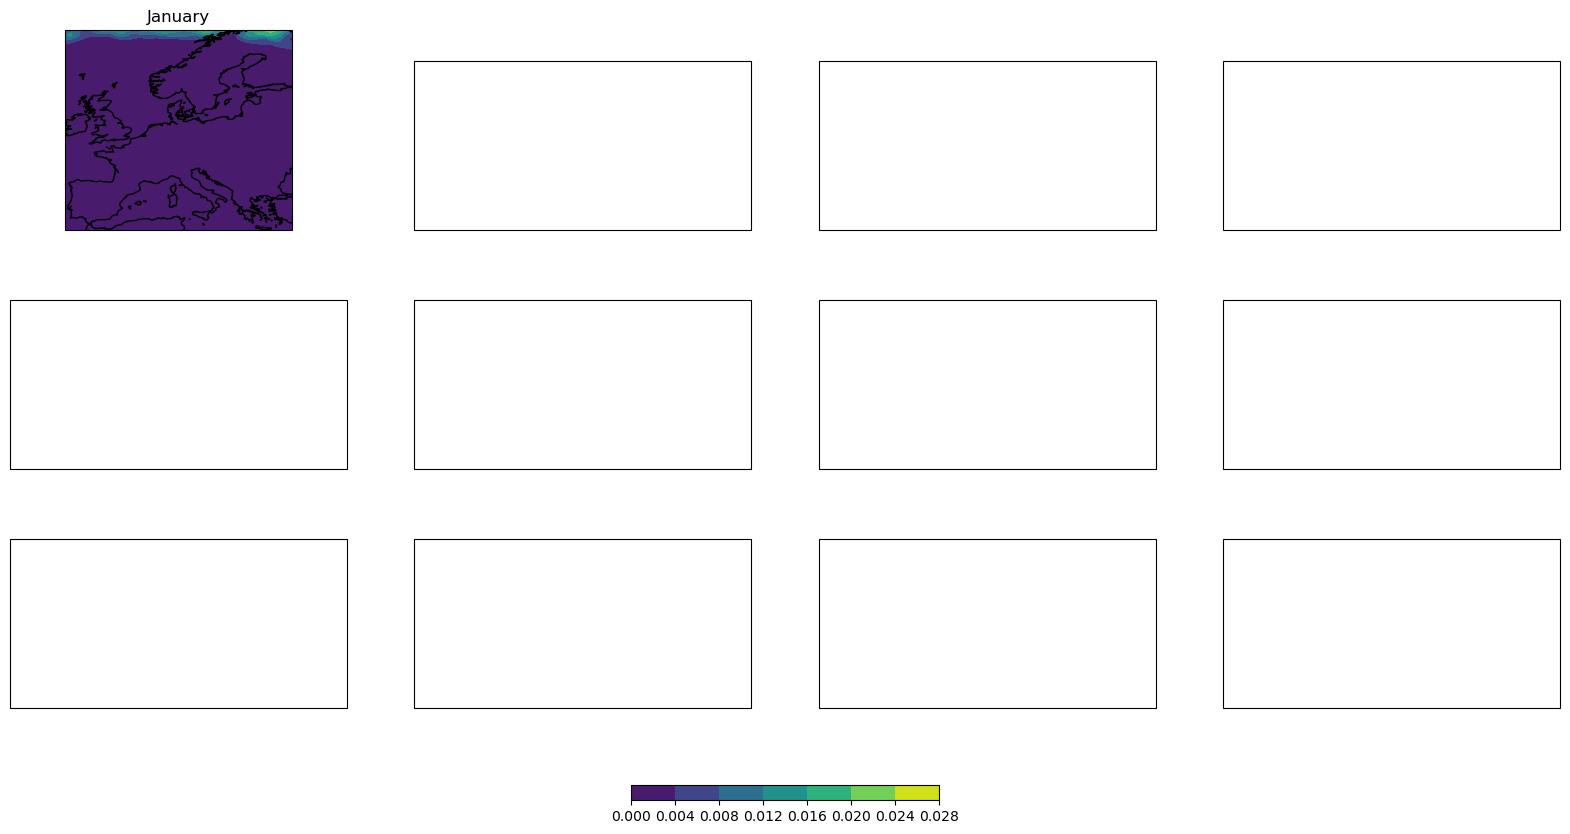

In [14]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# fig, axs = plt.subplots(figsize=(20, 10), nrows=3, ncols=4)
axs = axs.flatten()

for m in range(1):
    axs[m].add_feature(cfeature.COASTLINE)
    
    
    contour = axs[m].contourf(pvpot[m].longitude, pvpot[m].latitude, pvpot[m])
    axs[m].set_title(f"{calendar.month_name[m+1]}")

cbar = fig.colorbar(contour, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)


In [15]:
pvpot_xr = xr.Dataset()
pvpot_xr['pvpot']  = pvpot

We need to get the watt per time per area, watt per 

In [16]:
pvpot_xr


<xarray.Dataset> Size: 65MB
Dimensions:     (valid_time: 720, latitude: 141, longitude: 161)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-06-01 ... 2000-06-30T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    pvpot       (valid_time, latitude, longitude) float32 65MB 0.01157 ... 0.0

In [17]:
import geopandas as gpd

df = pvpot_xr.to_dataframe().reset_index()
gdf = gpd.GeoDataFrame(
    df,
    geometry = gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs = "EPSG:4326"
)

KeyboardInterrupt: 

In [ ]:
europe_mask = gpd.read_file("europe_10km.shp")

In [ ]:
europe_mask.set_crs("EPSG:4326")

In [ ]:
from shapely.geometry import MultiPoint
points2 = europe_mask.copy()
points2.geometry = points2.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))
points2.head()

In [ ]:
clipped_data = gdf.clip(points2)

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# fig, axs = plt.subplots(figsize=(20, 10), nrows=3, ncols=4)
axs = axs.flatten()

for m in range(1):
    axs[m].add_feature(cfeature.COASTLINE)
    
    
    contour = axs[m].contourf(clipped_data[m].longitude, clipped_data[m].latitude, pvpot[m])
    axs[m].set_title(f"{calendar.month_name[m+1]}")

cbar = fig.colorbar(contour, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)


## Array for area of the cells

In [27]:
pvpot['latitude'], pvpot['longitude']

(<xarray.DataArray 'latitude' (latitude: 141)> Size: 1kB
 array([70.  , 69.75, 69.5 , 69.25, 69.  , 68.75, 68.5 , 68.25, 68.  , 67.75,
        67.5 , 67.25, 67.  , 66.75, 66.5 , 66.25, 66.  , 65.75, 65.5 , 65.25,
        65.  , 64.75, 64.5 , 64.25, 64.  , 63.75, 63.5 , 63.25, 63.  , 62.75,
        62.5 , 62.25, 62.  , 61.75, 61.5 , 61.25, 61.  , 60.75, 60.5 , 60.25,
        60.  , 59.75, 59.5 , 59.25, 59.  , 58.75, 58.5 , 58.25, 58.  , 57.75,
        57.5 , 57.25, 57.  , 56.75, 56.5 , 56.25, 56.  , 55.75, 55.5 , 55.25,
        55.  , 54.75, 54.5 , 54.25, 54.  , 53.75, 53.5 , 53.25, 53.  , 52.75,
        52.5 , 52.25, 52.  , 51.75, 51.5 , 51.25, 51.  , 50.75, 50.5 , 50.25,
        50.  , 49.75, 49.5 , 49.25, 49.  , 48.75, 48.5 , 48.25, 48.  , 47.75,
        47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25, 46.  , 45.75, 45.5 , 45.25,
        45.  , 44.75, 44.5 , 44.25, 44.  , 43.75, 43.5 , 43.25, 43.  , 42.75,
        42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25, 41.  , 40.75, 40.5 , 40.25,
       

In [31]:
import math
def calculate_cell_area(lat1, lat2, lon1, lon2, radius=6371):
    # Convert degrees to radians
    lat1, lat2, lon1, lon2 = map(math.radians, [lat1, lat2, lon1, lon2])
    
    # Calculate the area
    area = radius**2 * abs(math.sin(lat2) - math.sin(lat1)) * abs(lon2 - lon1)
    return area

# Example: Calculate area of a cell
lat1, lat2 = 3, 3.25  # Latitude bounds
lon1, lon2 = 5, 5.25  # Longitude bounds
area = calculate_cell_area(lat1, lat2, lon1, lon2)
print(f"Area of the cell: {area:.2f} km²")

Area of the cell: 771.62 km²


In [28]:
def grid_cell_area(ds, radius=6371):
    """
    Berechnet die Fläche jeder Gitterzelle basierend auf lat/lon.
    
    Parameters:
        ds (xarray.Dataset): Dataset mit lat/lon-Dimensionen.
        radius (float): Erdradius in Kilometern (Standard: 6371 km).
        
    Returns:
        xarray.DataArray: Flächenwerte für alle Zellen.
    """
    # Sekunden pro Stunde (falls später benötigt)
    sechour = 3600 

    # Extrahiere die Koordinaten für Latitude und Longitude
    lat = ds['latitude'].values
    lon = ds['longitude'].values

    # Berechnung der Bounds (Lat/Lon-Zellenränder)
    lat_bounds = np.concatenate(([lat[0] - (lat[1] - lat[0]) / 2], 
                                  lat[:-1] + np.diff(lat) / 2, 
                                  [lat[-1] + (lat[-1] - lat[-2]) / 2]))
    lon_bounds = np.concatenate(([lon[0] - (lon[1] - lon[0]) / 2], 
                                  lon[:-1] + np.diff(lon) / 2, 
                                  [lon[-1] + (lon[-1] - lon[-2]) / 2]))

    # Flächendifferenzen in Radians
    dlat = np.abs(np.diff(np.sin(np.radians(lat_bounds))))
    dlon = np.abs(np.diff(lon_bounds)) * np.pi / 180

    # Gitter für dlat und dlon erstellen
    dlat_grid, dlon_grid = np.meshgrid(dlat, dlon, indexing="ij")

    # Flächenberechnung für jede Gitterzelle
    cell_areas = radius**2 * dlat_grid * dlon_grid

    # Rückgabe als DataArray
    area_da = xr.DataArray(
        cell_areas,
        coords={"lat": lat, "lon": lon},
        dims=["lat", "lon"],
        name="cell_area"
    )
    return area_da


In [39]:
ds_eu['cell_area'] = grid_cell_area(ds_eu)
ds_eu['pv_pot'] = pvpot

In [40]:
ds_eu

<xarray.Dataset> Size: 458MB
Dimensions:     (valid_time: 720, latitude: 141, longitude: 161, lat: 141,
                 lon: 161)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-06-01 ... 2000-06-30T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 12kB dask.array<chunksize=(720,), meta=np.ndarray>
  * lat         (lat) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * lon         (lon) float64 1kB -10.0 -9.75 -9.5 -9.25 ... 29.5 29.75 30.0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 65MB dask.array<chunksize=(720, 41, 40), meta=np.ndarray>
    cell_area   (lat, lon) float64 182kB 264.3 264.3 264.3 ... 633.0 633.0 633.0
    pv_pot      (valid_time, latitude, longitude) float32 65MB 0.01157 ... 0.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-22T21:21 GRIB to CDM+CF via cfgrib-0.9.1...

# Find the maximum area

In [41]:
from scipy.ndimage import label

# Berechne den Schwellenwert für die Top 30%
threshold = pvpot.quantile(0.7)

# Maske erstellen: 1 für Werte in den Top 30%, 0 sonst
mask = (pvpot >= threshold).astype(int)
ds['mask'] = mask

# Label zusammenhängende Regionen
labels, num_features = label(mask)
ds['region_labels'] = xr.DataArray(labels, coords=mask.coords, dims=mask.dims)

# Flächenwerte summieren
region_areas = ds.groupby('region_labels')['cell_area'].sum()

# Größte Region finden
largest_region_label = region_areas.idxmax()
largest_area = region_areas.max()

print(f"Größte zusammenhängende Region: Label {largest_region_label} mit Fläche {largest_area:.2f} km²")

# Plot der größten Region
largest_region_mask = (ds['region_labels'] == largest_region_label)
largest_region_mask.plot()


KeyError: 'cell_area'